<a href="https://colab.research.google.com/github/Kazi-Rakib-Hasan-Jawwad/fMRI_Project/blob/main/Rakib_ARIN0707_final_project_3D_24June.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Change the Colab setting as below before running** <br>
**Runtime --> Change Runtime Type --> Hardware accelerator: T4 GPU**


Lightweight 3‑D Vision Transformer + Masked‑Autoencoder (MAE) for fMRI
=====================================================================
Clean Colab‑ready script that:
• Loads the HCP_emotion_4D_sample.mat set (pre‑split 3200/800)
• Self‑supervised MAE pre‑trains a ViT encoder on 3‑D patches
• Fine‑tunes the encoder for binary Face vs Shape classification

Author: Kazi Rakib Hasan

Licence: CC BY-NC 4.0


In [ ]:
import os, sys, math, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tqdm import tqdm

In [ ]:
# ----------------------------------------------------
# 1. Setup and Configuration
# ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Mount Google drive

from google.colab import drive

drive.mount('/content/drive')
gdrive_dir = 'ARIN0707_project'

if not os.path.exists('/content/drive/My Drive/' + gdrive_dir):
  os.makedirs('/content/drive/My Drive/' + gdrive_dir)

os.chdir('/content/drive/My Drive/' + gdrive_dir)

data_path = '/content/drive/My Drive/' + gdrive_dir

ROOT = '/content/drive/My Drive/' + gdrive_dir
os.chdir(ROOT)

print(f"Project root: {ROOT}")

# Always‑valid directory for saving checkpoints
SAVE_DIR = ROOT if os.path.isdir(ROOT) else os.getcwd()

print(data_path)

Mounted at /content/drive
Project root: /content/drive/My Drive/ARIN0707_project
/content/drive/My Drive/ARIN0707_project


In [ ]:
# Download dataset
# You must have at least 5GB free space to download the dataset in your Google Drive
# Check your Google Drive after download is done

# Once you downloaded the dataset, you don't need to run this cell


if not os.path.exists(data_path + '/HCP_emotion_4D_sample.mat'):
  !pip install pydrive
  print('\n\n')
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  gdrive = GoogleDrive(gauth)

  # Download the data with Google Drive link
  # Download takes about 5 mins.
  img_file = gdrive.CreateFile({'id':'1OZQW_KkOsn_3-CsLHB018T_3V3huGB7E'})
  img_file.GetContentFile(data_path + '/HCP_emotion_4D_sample.mat')

In [ ]:
# Load Data from Google Drive
# You can load whole dataset, or split the dataset into individual 3D volumes and then load them with custom dataloader.

data = loadmat(data_path + '/HCP_emotion_4D_sample.mat')

# Train: 3200, Test: 800
# Report your model's performance only on designated testset (800 samples)
# You are not allowed to mix data samples between the predefined train / test datasets.

X_train = data['X_train']
y_train = data['y_train']
ids_train = data['ids_train']

X_test = data['X_test']
y_test = data['y_test']
ids_test = data['ids_test']

del data

In [ ]:
# Check data shape

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('ids_train shape: ', ids_train.shape)

print('\n')

print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('ids_test shape: ', ids_test.shape)

X_train shape:  (3200, 53, 63, 46)
y_train shape:  (3200, 1)
ids_train shape:  (3200,)


X_test shape:  (800, 53, 63, 46)
y_test shape:  (800, 1)
ids_test shape:  (800,)


In [ ]:
# Robust DynamicFMRI_Dataset
class DynamicFMRI_Dataset(Dataset):
    def __init__(self, X, y, augment_ratio=0.0, normalize=False):
        self.X_original = torch.from_numpy(X).float()
        self.y_original = torch.from_numpy(y).long()
        self.normalize = normalize

        self.original_size = len(self.X_original)
        self.do_augment = augment_ratio > 0
        self.augmentation_indices = None

        if self.do_augment:
            self.num_to_augment = int(self.original_size * augment_ratio)
            all_indices = np.arange(self.original_size)
            np.random.shuffle(all_indices)
            self.augmentation_indices = torch.from_numpy(all_indices[:self.num_to_augment])
            print(f"Created dataset with {self.num_to_augment} on-the-fly augmented samples.")


    def __len__(self):
        return self.original_size + self.num_to_augment if self.do_augment else self.original_size

    def __getitem__(self, idx):
        if not self.do_augment or idx < self.original_size:
            x_item = self.X_original[idx]
            y_item = self.y_original[idx]
        else:
            # This check ensures self.augmentation_indices is not None before subscripting
            if self.augmentation_indices is not None:
                mapped_idx = self.augmentation_indices[idx - self.original_size]
                x_item = self.X_original[mapped_idx]
                y_item = self.y_original[mapped_idx]
                x_item = torch.flip(x_item, dims=[-1])
            else:
                # This case should not be reached with the corrected __init__
                raise RuntimeError("Augmentation indices are not initialized!")


        if self.normalize:
            mean = x_item.mean()
            std = x_item.std()
            if std > 1e-6:
                x_item = (x_item - mean) / std
        return x_item, y_item

In [ ]:
batch_size = 8
train_dataset = DynamicFMRI_Dataset(X_train, y_train, augment_ratio=0.1, normalize=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_dataset  = DynamicFMRI_Dataset(X_test,  y_test, augment_ratio=0.0, normalize=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

_, img_depth, img_height, img_width = X_train.shape
del X_train, y_train, X_test, y_test

Created dataset with 320 on-the-fly augmented samples.


In [ ]:
# ----------------------------------------------------
# 2. Patch embedding
# 2D Patch Embedding for spatial slices
# ----------------------------------------------------

class PatchEmbedding2D(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, d_model):
        super().__init__()
        self.img_h, self.img_w = img_size
        self.ph, self.pw = patch_size
        self.num_patches = (self.img_h // self.ph) * (self.img_w // self.pw)

        self.proj = nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, d_model))
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.normal_(self.pos_embed, std=0.02)

    def forward(self, x): # x: (B, C, H, W)
        x = self.proj(x).flatten(2).transpose(1, 2) # (B, N, d_model)
        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), 1) + self.pos_embed
        return x # (B, N+1, d_model)

In [ ]:
# ----------------------------------------------------
# 3. Transformer Encoder / Decoder
# ----------------------------------------------------

# ViT Encoder for Spatial Feature Extraction
class ViTEncoder(nn.Module):
    def __init__(self, d_model, n_layers, nhead, dropout):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout, batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, n_layers)
    def forward(self, x):
        return self.encoder(x)

# Temporal Transformer
class TemporalTransformer(nn.Module):
    def __init__(self, d_model, n_layers, nhead, dropout):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model * 2, dropout, batch_first=True, norm_first=True)
        self.tfl = nn.TransformerEncoder(layer, n_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x): # x: (B, T, D) where T is sequence length
        return self.norm(self.tfl(x))


# MAE Decoder for 2D Patches
class MAEDecoder2D(nn.Module):
    def __init__(self, d_model, patch_dim, n_layers, nhead, dropout):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model * 2, dropout, batch_first=True)
        self.decoder = nn.TransformerEncoder(layer, n_layers)
        self.out = nn.Linear(d_model, patch_dim)
    def forward(self, x):
        return self.out(self.decoder(x))


In [ ]:
# ----------------------------------------------------
# 4. Masked Autoencoder
# ----------------------------------------------------
class MAEforSlices(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, d_model, n_enc, n_dec, nhead, dropout, mask_ratio):
        super().__init__()
        self.patch_embed = PatchEmbedding2D(img_size, patch_size, in_channels, d_model)
        self.encoder = ViTEncoder(d_model, n_enc, nhead, dropout)
        self.mask_ratio = mask_ratio
        self.d_model = d_model
        self.N = self.patch_embed.num_patches
        self.patch_dim = int(np.prod(patch_size) * in_channels)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.decoder = MAEDecoder2D(d_model, self.patch_dim, n_layers=n_dec, nhead=nhead, dropout=dropout)

        # Create and initialize a positional embedding for the decoder
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.N, d_model))
        nn.init.normal_(self.decoder_pos_embed, std=0.02)
        nn.init.normal_(self.mask_token, std=0.02)


    def forward_loss(self, pred, target, mask):
        mean = target.mean(dim=-1, keepdim=True)
        var = target.var(dim=-1, keepdim=True)
        target = (target - mean) / (var + 1.e-6)**.5
        target_masked = target.gather(1, mask.unsqueeze(-1).expand(-1, -1, self.patch_dim))
        pred_masked = pred.gather(1, mask.unsqueeze(-1).expand(-1, -1, self.patch_dim))
        return F.mse_loss(pred_masked, target_masked)

    def forward(self, x_2d):
        B, H, W = x_2d.shape
        x = x_2d.unsqueeze(1)
        seq = self.patch_embed(x)
        cls, patches = seq[:, :1], seq[:, 1:]
        with torch.no_grad():
            target_patches = x.unfold(2, self.patch_embed.ph, self.patch_embed.ph).unfold(3, self.patch_embed.pw, self.patch_embed.pw)
            target_patches = target_patches.contiguous().view(B, -1, self.patch_dim)
        num_mask = int(self.N * self.mask_ratio)
        ids_shuffle = torch.rand(B, self.N, device=x.device).argsort(dim=1)
        ids_restore = ids_shuffle.argsort(dim=1)
        ids_mask = ids_shuffle[:, :num_mask]
        ids_keep = ids_shuffle[:, num_mask:]
        patches_keep = patches.gather(1, ids_keep.unsqueeze(-1).expand(-1, -1, self.d_model))
        enc_in = torch.cat([cls, patches_keep], 1)
        enc_out = self.encoder(enc_in)
        mask_tokens = self.mask_token.expand(B, num_mask, -1)
        dec_in_full = torch.cat([enc_out[:, 1:], mask_tokens], 1)
        dec_in = dec_in_full.gather(1, ids_restore.unsqueeze(-1).expand(-1, -1, self.d_model))

        # Add the decoder positional embedding to the decoder input
        recon = self.decoder(dec_in + self.decoder_pos_embed)
        return self.forward_loss(recon, target_patches, ids_mask)

In [ ]:
# ----------------------------------------------------
# 5. Spatio-Temporal Classifier
# ----------------------------------------------------
class SpatioTemporalClassifier(nn.Module):
    def __init__(self, img_size, time_steps, patch_size, in_channels, d_model,
                 n_spatial_enc, n_temporal_enc, nhead_spatial, nhead_temporal, dropout, n_classes):
        super().__init__()
        self.d_model = d_model
        # 1. Spatial Encoder (processes each slice)
        self.patch_embed = PatchEmbedding2D(img_size, patch_size, in_channels, d_model)
        self.spatial_encoder = ViTEncoder(d_model, n_spatial_enc, nhead_spatial, dropout)
        # 2. Temporal Encoder (processes sequence of slice representations)
        # Adding temporal positional embedding
        self.temporal_pos_embed = nn.Parameter(torch.zeros(1, time_steps, d_model))
        nn.init.normal_(self.temporal_pos_embed, std=0.02)
        self.temporal_encoder = TemporalTransformer(d_model, n_temporal_enc, nhead_temporal, dropout)
        # 3. Predictor
        self.predictor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, n_classes)
        )

    def forward(self, x): # x: (B, D, H, W)
        B, D, H, W = x.shape
        x_slices = x.view(B * D, H, W).unsqueeze(1) # -> (B*D, 1, H, W)

        # Spatial encoding for each slice
        spatial_seq = self.patch_embed(x_slices)    # (B*D, N_2d+1, d)
        spatial_out = self.spatial_encoder(spatial_seq) # (B*D, N_2d+1, d)
        slice_repr = spatial_out[:, 0]              # Get CLS token -> (B*D, d)

        # Form temporal sequence
        temporal_seq = slice_repr.view(B, D, self.d_model) # -> (B, D, d)
        temporal_seq += self.temporal_pos_embed # Add temporal pos encoding

        # Temporal encoding
        temporal_out = self.temporal_encoder(temporal_seq) # -> (B, D, d)

        # Predictor: Mean pool over time dimension
        pooled_out = temporal_out.mean(dim=1) # -> (B, d)
        logits = self.predictor(pooled_out)
        return logits

In [ ]:
# ----------------------------------------------------
# 6. Hyperparameters
# ----------------------------------------------------
# Architectural params
patch_size_2d = (7, 2) #
d_model    = 192
n_spatial_enc = 4
n_dec_mae = 2
n_temporal_enc = 2

# Spatial and temporal components
nhead_spatial = 8
nhead_temporal = 8

# Training params
dropout    = 0.1
mask_ratio = 0.65
num_classes= 2
mae_epochs = 100
clf_epochs = 20
mae_lr     = 1.5e-4
clf_lr     = 3e-5
warmup_epochs = 5

In [ ]:
# This error is related to torch._dynamo and can be triggered by optimizer instantiation.
# Disabling torch.compile is a robust workaround.
if hasattr(torch, 'compiler'):
    torch.compiler.disable()

In [ ]:
# ----------------------------------------------------
# 7. Pre‑train MAE
# ----------------------------------------------------
print("\n--- Starting MAE Pre-training on 2D Slices ---")
mae = MAEforSlices(
    (img_height, img_width), patch_size_2d, 1, d_model,
    n_spatial_enc, n_dec_mae, nhead_spatial, dropout, mask_ratio
).to(device)

opt_mae = optim.AdamW(mae.parameters(), lr=mae_lr, betas=(0.9, 0.95), weight_decay=0.05)

def get_lr(it, total_it, warmup_it):
    if it < warmup_it:
        return mae_lr * it / warmup_it
    if it > total_it:
        return 1e-6
    decay_ratio = (it - warmup_it) / (total_it - warmup_it)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return 1e-6 + coeff * (mae_lr - 1e-6)

scaler = GradScaler(enabled=(device.type == 'cuda'))
total_iterations = mae_epochs * len(train_loader)
warmup_iterations = warmup_epochs * len(train_loader)
it_num = 0

for ep in range(mae_epochs):
    mae.train()
    total_loss = 0
    lr = 0.0
    pbar = tqdm(train_loader, desc=f"MAE Ep {ep+1}/{mae_epochs}")
    for imgs, _ in pbar:
        lr = get_lr(it_num, total_iterations, warmup_iterations)
        for param_group in opt_mae.param_groups:
            param_group['lr'] = lr
        imgs = imgs.to(device)
        slices = imgs.view(-1, img_height, img_width)
        opt_mae.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type == 'cuda')):
            loss = mae(slices)
        scaler.scale(loss).backward()
        scaler.step(opt_mae)
        scaler.update()
        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item(), lr=lr)
        it_num += 1

    avg_loss = total_loss / len(train_loader)
    print(f"MAE Epoch {ep+1}/{mae_epochs} | Avg Loss: {avg_loss:.4f} | Final LR: {lr:.2e}")

print("MAE pre-training done.\n")


--- Starting MAE Pre-training on 2D Slices ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/tmp/ipython-input-20-1172366045.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == 'cuda'))
MAE Ep 1/40:   0%|          | 0/440 [00:00<?, ?it/s]/tmp/ipython-input-20-1172366045.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
MAE Ep 1/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.406, lr=2.99e-5]


MAE Epoch 1/40 | Avg Loss: 0.4521 | Final LR: 2.99e-05


MAE Ep 2/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.397, lr=5.99e-5]


MAE Epoch 2/40 | Avg Loss: 0.4002 | Final LR: 5.99e-05


MAE Ep 3/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.397, lr=8.99e-5]


MAE Epoch 3/40 | Avg Loss: 0.3979 | Final LR: 8.99e-05


MAE Ep 4/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.397, lr=0.00012]


MAE Epoch 4/40 | Avg Loss: 0.3969 | Final LR: 1.20e-04


MAE Ep 5/40: 100%|██████████| 440/440 [01:40<00:00,  4.36it/s, loss=0.393, lr=0.00015]


MAE Epoch 5/40 | Avg Loss: 0.3961 | Final LR: 1.50e-04


MAE Ep 6/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.397, lr=0.00015]


MAE Epoch 6/40 | Avg Loss: 0.3952 | Final LR: 1.50e-04


MAE Ep 7/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.396, lr=0.000149]


MAE Epoch 7/40 | Avg Loss: 0.3939 | Final LR: 1.49e-04


MAE Ep 8/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.389, lr=0.000147]


MAE Epoch 8/40 | Avg Loss: 0.3924 | Final LR: 1.47e-04


MAE Ep 9/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.388, lr=0.000145]


MAE Epoch 9/40 | Avg Loss: 0.3908 | Final LR: 1.45e-04


MAE Ep 10/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.387, lr=0.000143]


MAE Epoch 10/40 | Avg Loss: 0.3894 | Final LR: 1.43e-04


MAE Ep 11/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.387, lr=0.000139]


MAE Epoch 11/40 | Avg Loss: 0.3879 | Final LR: 1.39e-04


MAE Ep 12/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.392, lr=0.000136]


MAE Epoch 12/40 | Avg Loss: 0.3863 | Final LR: 1.36e-04


MAE Ep 13/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.389, lr=0.000132]


MAE Epoch 13/40 | Avg Loss: 0.3847 | Final LR: 1.32e-04


MAE Ep 14/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.376, lr=0.000127]


MAE Epoch 14/40 | Avg Loss: 0.3831 | Final LR: 1.27e-04


MAE Ep 15/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.379, lr=0.000122]


MAE Epoch 15/40 | Avg Loss: 0.3814 | Final LR: 1.22e-04


MAE Ep 16/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.375, lr=0.000117]


MAE Epoch 16/40 | Avg Loss: 0.3797 | Final LR: 1.17e-04


MAE Ep 17/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.371, lr=0.000111]


MAE Epoch 17/40 | Avg Loss: 0.3778 | Final LR: 1.11e-04


MAE Ep 18/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.372, lr=0.000105]


MAE Epoch 18/40 | Avg Loss: 0.3762 | Final LR: 1.05e-04


MAE Ep 19/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.379, lr=9.85e-5]


MAE Epoch 19/40 | Avg Loss: 0.3748 | Final LR: 9.85e-05


MAE Ep 20/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.368, lr=9.21e-5]


MAE Epoch 20/40 | Avg Loss: 0.3734 | Final LR: 9.21e-05


MAE Ep 21/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.376, lr=8.55e-5]


MAE Epoch 21/40 | Avg Loss: 0.3720 | Final LR: 8.55e-05


MAE Ep 22/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.376, lr=7.89e-5]


MAE Epoch 22/40 | Avg Loss: 0.3706 | Final LR: 7.89e-05


MAE Ep 23/40: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.37, lr=7.22e-5]


MAE Epoch 23/40 | Avg Loss: 0.3695 | Final LR: 7.22e-05


MAE Ep 24/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.365, lr=6.55e-5]


MAE Epoch 24/40 | Avg Loss: 0.3684 | Final LR: 6.55e-05


MAE Ep 25/40: 100%|██████████| 440/440 [01:40<00:00,  4.36it/s, loss=0.368, lr=5.89e-5]


MAE Epoch 25/40 | Avg Loss: 0.3673 | Final LR: 5.89e-05


MAE Ep 26/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.369, lr=5.25e-5]


MAE Epoch 26/40 | Avg Loss: 0.3663 | Final LR: 5.25e-05


MAE Ep 27/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.366, lr=4.62e-5]


MAE Epoch 27/40 | Avg Loss: 0.3654 | Final LR: 4.62e-05


MAE Ep 28/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.364, lr=4.02e-5]


MAE Epoch 28/40 | Avg Loss: 0.3648 | Final LR: 4.02e-05


MAE Ep 29/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.364, lr=3.45e-5]


MAE Epoch 29/40 | Avg Loss: 0.3641 | Final LR: 3.45e-05


MAE Ep 30/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.359, lr=2.91e-5]


MAE Epoch 30/40 | Avg Loss: 0.3633 | Final LR: 2.91e-05


MAE Ep 31/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.357, lr=2.4e-5]


MAE Epoch 31/40 | Avg Loss: 0.3628 | Final LR: 2.40e-05


MAE Ep 32/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.363, lr=1.94e-5]


MAE Epoch 32/40 | Avg Loss: 0.3623 | Final LR: 1.94e-05


MAE Ep 33/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.363, lr=1.52e-5]


MAE Epoch 33/40 | Avg Loss: 0.3622 | Final LR: 1.52e-05


MAE Ep 34/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.365, lr=1.16e-5]


MAE Epoch 34/40 | Avg Loss: 0.3617 | Final LR: 1.16e-05


MAE Ep 35/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.365, lr=8.38e-6]


MAE Epoch 35/40 | Avg Loss: 0.3614 | Final LR: 8.38e-06


MAE Ep 36/40: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.359, lr=5.76e-6]


MAE Epoch 36/40 | Avg Loss: 0.3611 | Final LR: 5.76e-06


MAE Ep 37/40: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.361, lr=3.69e-6]


MAE Epoch 37/40 | Avg Loss: 0.3609 | Final LR: 3.69e-06


MAE Ep 38/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.362, lr=2.2e-6]


MAE Epoch 38/40 | Avg Loss: 0.3610 | Final LR: 2.20e-06


MAE Ep 39/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.363, lr=1.3e-6]


MAE Epoch 39/40 | Avg Loss: 0.3608 | Final LR: 1.30e-06


MAE Ep 40/40: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.358, lr=1e-6]

MAE Epoch 40/40 | Avg Loss: 0.3608 | Final LR: 1.00e-06
MAE pre-training done.



In [ ]:
# ----------------------------------------------------
# 8. Fine-tune Spatio-Temporal Classifier
# ----------------------------------------------------

print("--- Starting Spatio-Temporal Fine-tuning ---")
clf = SpatioTemporalClassifier(
    img_size=(img_height, img_width), time_steps=img_depth,
    patch_size=patch_size_2d, in_channels=1, d_model=d_model,
    n_spatial_enc=n_spatial_enc, n_temporal_enc=n_temporal_enc,
    nhead_spatial=nhead_spatial, nhead_temporal=nhead_temporal,
    dropout=dropout, n_classes=num_classes
).to(device)

clf.patch_embed.load_state_dict(mae.patch_embed.state_dict())
clf.spatial_encoder.load_state_dict(mae.encoder.state_dict())
print("Weights from MAE's PatchEmbed and Spatial Encoder transferred to Classifier.")

opt_clf = optim.AdamW(clf.parameters(), lr=clf_lr, weight_decay=0.05)
sched_clf = optim.lr_scheduler.StepLR(opt_clf, step_size=int(clf_epochs * 0.7), gamma=0.1)
criterion = nn.CrossEntropyLoss()
# Instantiate a GradScaler for the fine-tuning loop
scaler_clf = GradScaler(enabled=(device.type == 'cuda'))

train_losses, test_losses = [], []
train_accs,  test_accs  = [], []
best_acc = 0.0

for ep in range(clf_epochs):
    # --- Train ---
    clf.train()
    running_loss = train_correct = train_total = 0
    pbar_train = tqdm(train_loader, desc=f"CLF Train Ep {ep+1}/{clf_epochs}")
    for imgs, labels in pbar_train:
        imgs, labels = imgs.to(device), labels.squeeze(1).to(device)
        opt_clf.zero_grad(set_to_none=True)
        # Use autocast for the forward pass
        with autocast(enabled=(device.type == "cuda")):
            logits = clf(imgs)
            loss = criterion(logits, labels)
        # Use scaler for backward pass and optimizer step
        scaler_clf.scale(loss).backward()
        scaler_clf.step(opt_clf)
        scaler_clf.update()

        running_loss += loss.item()
        train_correct += (logits.argmax(1) == labels).sum().item()
        train_total += labels.size(0)
        pbar_train.set_postfix(acc=100*train_correct/train_total)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * train_correct / train_total)
    sched_clf.step()

    # --- Validation ---
    clf.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        pbar_val = tqdm(test_loader, desc=f"CLF Val Ep {ep+1}/{clf_epochs}")
        for imgs, labels in pbar_val:
            imgs, labels = imgs.to(device), labels.squeeze(1).to(device)
            # Use autocast here as well for consistency, though it's not strictly necessary without a backward pass
            with autocast(enabled=(device.type == "cuda")):
                logits = clf(imgs)
                loss   = criterion(logits, labels)
            val_loss += loss.item()
            val_correct += (logits.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            pbar_val.set_postfix(acc=100*val_correct/val_total)

    test_losses.append(val_loss / len(test_loader))
    val_acc = 100 * val_correct / val_total
    test_accs.append(val_acc)


    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(clf.state_dict(), os.path.join(SAVE_DIR, "best_spatiotemporal_classifier.pt"))
        print(f"Epoch {ep+1} | New best accuracy: {best_acc:.2f}% | Model saved.")

    print(f"Epoch {ep+1}/{clf_epochs}: Train Acc {train_accs[-1]:.2f}% | Val Acc {val_acc:.2f}% (Best: {best_acc:.2f}%)")

print("\nFine-tuning complete.")

/tmp/ipython-input-21-989343707.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_clf = GradScaler(enabled=(device.type == 'cuda'))


--- Starting Spatio-Temporal Fine-tuning ---
Weights from MAE's PatchEmbed and Spatial Encoder transferred to Classifier.


CLF Train Ep 1/10:   0%|          | 0/440 [00:00<?, ?it/s]/tmp/ipython-input-21-989343707.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
CLF Val Ep 1/10:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipython-input-21-989343707.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
CLF Val Ep 1/10: 100%|██████████| 100/100 [00:08<00:00, 11.51it/s, acc=81.6]


Epoch 1 | New best accuracy: 81.62% | Model saved.
Epoch 1/10: Train Acc 76.82% | Val Acc 81.62% (Best: 81.62%)


CLF Val Ep 2/10: 100%|██████████| 100/100 [00:09<00:00, 10.81it/s, acc=87.5]


Epoch 2 | New best accuracy: 87.50% | Model saved.
Epoch 2/10: Train Acc 87.33% | Val Acc 87.50% (Best: 87.50%)


CLF Val Ep 3/10: 100%|██████████| 100/100 [00:08<00:00, 12.33it/s, acc=87.6]


Epoch 3 | New best accuracy: 87.62% | Model saved.
Epoch 3/10: Train Acc 88.75% | Val Acc 87.62% (Best: 87.62%)


CLF Val Ep 4/10: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s, acc=86.9]


Epoch 4/10: Train Acc 91.16% | Val Acc 86.88% (Best: 87.62%)


CLF Val Ep 5/10: 100%|██████████| 100/100 [00:08<00:00, 12.18it/s, acc=89.6]


Epoch 5 | New best accuracy: 89.62% | Model saved.
Epoch 5/10: Train Acc 92.27% | Val Acc 89.62% (Best: 89.62%)


CLF Val Ep 6/10: 100%|██████████| 100/100 [00:09<00:00, 11.05it/s, acc=88.5]


Epoch 6/10: Train Acc 93.10% | Val Acc 88.50% (Best: 89.62%)


CLF Val Ep 7/10: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s, acc=89.8]


Epoch 7 | New best accuracy: 89.75% | Model saved.
Epoch 7/10: Train Acc 94.29% | Val Acc 89.75% (Best: 89.75%)


CLF Val Ep 8/10: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s, acc=91]


Epoch 8 | New best accuracy: 91.00% | Model saved.
Epoch 8/10: Train Acc 97.67% | Val Acc 91.00% (Best: 91.00%)


CLF Val Ep 9/10: 100%|██████████| 100/100 [00:09<00:00, 11.06it/s, acc=90]


Epoch 9/10: Train Acc 97.81% | Val Acc 90.00% (Best: 91.00%)


CLF Val Ep 10/10: 100%|██████████| 100/100 [00:08<00:00, 12.22it/s, acc=90.5]

Epoch 10/10: Train Acc 98.18% | Val Acc 90.50% (Best: 91.00%)

Fine-tuning complete.


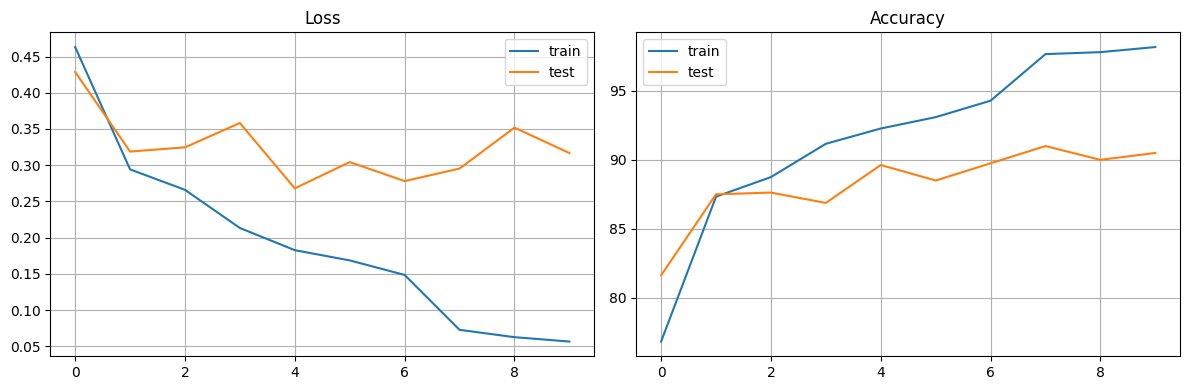

In [ ]:
# ----------------------------------------------------
# 9. Plots
# ----------------------------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses,label='train'); plt.plot(test_losses,label='test'); plt.title('Loss'); plt.legend(); plt.grid()
plt.subplot(1,2,2)
plt.plot(train_accs,label='train'); plt.plot(test_accs,label='test'); plt.title('Accuracy'); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()

In [ ]:
print("completed")